In [8]:
import cv2
import numpy as np
import mediapipe as mp
import torch
from torch import nn
from einops import rearrange
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 必要な分だけピックアップ
reduced_keypoints = [
    0,
    2,
    5,
    7,
    8,
    11,
    12,
    13,
    14,
    15,
    16,
    23,
    24,
    25,
    26,
    27,
    28,
]
E = [
    [15, 13],
    [13, 11],
    [16, 14],
    [14, 12],
    [11, 12],
    [5, 11],
    [6, 12],
    [5, 6],
    [5, 7],
    [6, 8],
    [7, 9],
    [8, 10],
    [1, 2],
    [0, 1],
    [0, 2],
    [1, 3],
    [2, 4],
    [3, 5],
    [4, 6],
]
num_node = len(reduced_keypoints)


# APIで推定した座標をnumpy配列に変換
def make_spatial_feature_mx(hand_landmarks, width, height):
    spatial_mx = []
    for i, lm in enumerate(hand_landmarks.landmark):
        if i in reduced_keypoints:
            x = lm.x * width
            y = lm.y * height
            spatial_mx.append([x, y])
    spatial_mx = np.array(spatial_mx)
    return spatial_mx  # shape (V, C)


# videoの読み込み
cap = cv2.VideoCapture("video.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

X = []
# pose推定の設定
mp_pose = mp.solutions.pose
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for idx in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        # 1秒ごとに取得
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx * fps)
        success, image = cap.read()
        if not success:
            break

        image.flags.writeable = False
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(img)

        # 各フレームでの特徴行列を作成
        X_t = make_spatial_feature_mx(results.pose_landmarks, width, height)
        # 時間方向に追加する
        X.append(X_t)
        idx += 1

X = np.array(X)
X.shape  # T V C

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


(6, 17, 2)

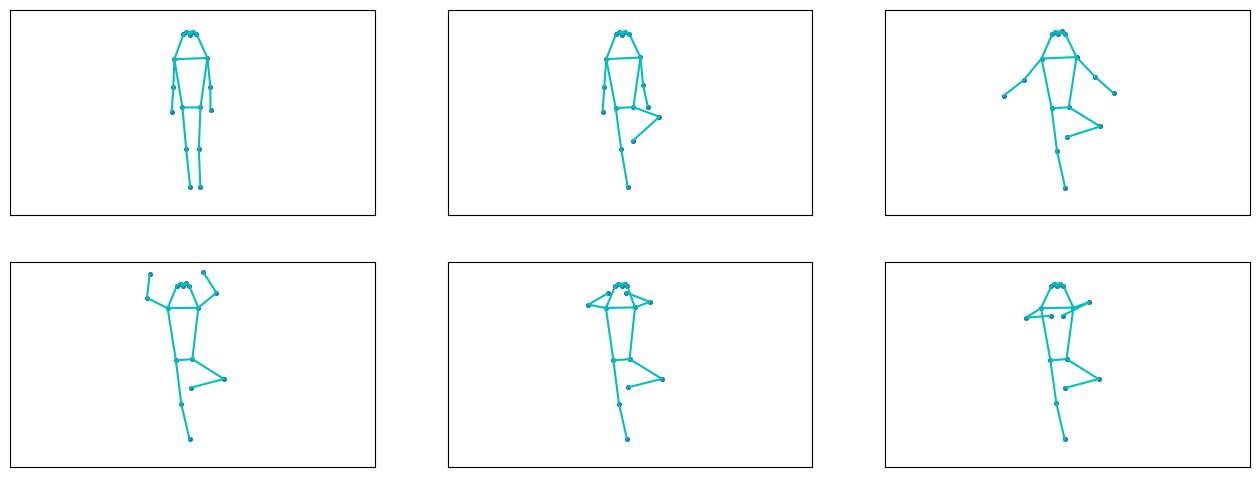

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
        
fig, ax = plt.subplots(2, 3, figsize=(16.0, 6.0) )
for i in range(6):
    r = i // 3
    c = i % 3
    # エッジを描画
    for e in E:
        ax[r,c].plot([X[i, e[0], 0], X[i, e[1], 0]], [X[i, e[0], 1], X[i, e[1], 1]], "c")
    # ノードを描画
    ax[r,c].scatter(X[i, :, 0], X[i, :, 1], s=7)
    # その他設定
    ax[r,c].set_xlim([0, width])
    ax[r,c].set_ylim([0, height])
    ax[r,c].set_aspect('equal', 'box')
    ax[r,c].set_xticks([])
    ax[r,c].set_yticks([])
    ax[r,c].invert_yaxis()


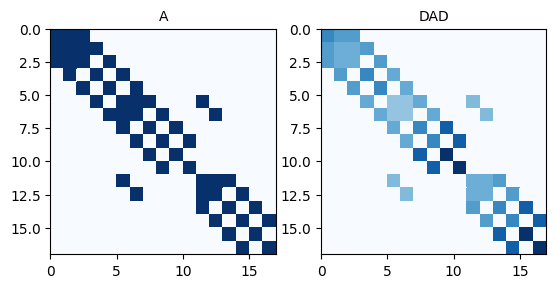

In [4]:
def edge2mat(E, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in E:
        A[j, i] = 1
    return A

def get_D(A, pow=-1):
    d_ii = np.sum(A, 0)
    D = np.zeros_like(A)
    for i in range(len(A)):
        D[i, i] = d_ii[i]**(pow)
    return D

reversed_E = [[j, i] for [i, j] in E]
I = [[i, i] for i in range(num_node)] 
new_E = E + reversed_E + I

# 隣接行列の作成
A = edge2mat(new_E, num_node)  # ノードの数は5

# DAD
D = get_D(A,pow=-0.5)
DAD = D @ A @ D

fig, ax = plt.subplots(1, 2)
ax[0].pcolor(A, cmap=plt.cm.Blues)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('A', fontsize=10)
ax[0].invert_yaxis()

ax[1].pcolor(DAD, cmap=plt.cm.Blues)
ax[1].set_aspect('equal', 'box')
ax[1].set_title('DAD', fontsize=10)
ax[1].invert_yaxis()

In [6]:
X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = rearrange(X_tensor, "T V C -> C T V")    # チャネルファースト
A_tensor = torch.tensor(A, dtype=torch.float32)
D_tensor = torch.tensor(D, dtype=torch.float32)

# 重みをConvとして設定
in_channels = 2      # x座標とy座標なので
out_channels = 8     # 適当です

spatial_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)  # 1x1conv

# 行列計算
XW = spatial_conv(X_tensor)
# einsumを使います.
# einsum使いたくないのであれば，for文で回すか，隣接行列をフレーム分拡張するなどの実装もできると思います．
spatial_X_tensor = torch.einsum('CTV,VW->CTW', XW, D_tensor @ A_tensor @ D_tensor)

print(f"入力のサイズ：{X_tensor.size()}")
print(f"出力のサイズ：{spatial_X_tensor.size()}")

入力のサイズ：torch.Size([2, 6, 17])
出力のサイズ：torch.Size([8, 6, 17])


In [7]:
t_kernel = 3  # 何フレーム分畳み込むかの設定
t_stride = 1  # 時間方向のストライド
padding = ((t_kernel - 1) // 2, 0)  # 入力と同じサイズの出力にするために
temporal_conv = nn.Conv2d(
    out_channels,
    out_channels,
    kernel_size=(t_kernel, 1),
    stride=(t_stride, 1),
    padding=padding,
)

temporal_X_tensor = temporal_conv(spatial_X_tensor)

print(f"入力サイズ：{temporal_X_tensor.size()}")
print(f"出力サイズ：{temporal_X_tensor.size()}")

入力サイズ：torch.Size([8, 6, 17])
出力サイズ：torch.Size([8, 6, 17])


In [10]:
class STBlock(nn.Module):
    def __init__(self, in_features, out_features, t_kernel=9, t_stride=1):
        super(STBlock, self).__init__()
        # args
        self.in_features = in_features
        self.out_features = out_features
        padding = ((t_kernel - 1) // 2, 0)

        # layer
        self.spatial_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.temporal_conv = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=(t_kernel, 1),
            stride=(t_stride, 1),
            padding=padding,
        )

    def forward(self, input, adj):
        """
        Args:
            input (Tensor): graph feature
                            input.size() = (N, C, V, T)
            adj (Tensor): normalized adjacency matrix.
                          e.g. DAD or DA
                          input.size() = (V, V)
        Returns:
            Tensor: out.size() = (N, C_out, V, T)
        """
        XW = self.spatial_conv(input)
        spatial_feature = torch.einsum("NCTV,VW->NCTW", XW, adj)
        temporal_feature = self.temporal_conv(spatial_feature)
        return temporal_feature

In [11]:
# フェイクデータ
X = np.random.randn(10, 2, 10, 17)  # num_data, node_feature, time, num_node
y = [0] * 5 + [1] * 5
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int64)
data = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(data, batch_size=10)

# DADの定義
A_tensor = torch.tensor(A, dtype=torch.float32)
D_tensor = torch.tensor(D, dtype=torch.float32)
DAD = D_tensor @ A_tensor @ D_tensor

# モデルの定義
model = STBlock(in_channels, out_channels)

# バッチ処理
for input, label in loader:
    new_X_tensor = model(input, DAD)

new_X_tensor.size()

torch.Size([10, 8, 10, 17])